In [1]:
import calendar
import warnings

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

## Import Data


In [3]:
df = pd.concat(
    [
        pd.read_json("data/raw/arv-anshul.json"),
        pd.read_json("data/raw/itsarv.json"),
    ]
)
print(df.shape)
df.head()

(14654, 8)


,header,title,titleUrl,subtitles,time,products,activityControls,details
0,YouTube,Watched I Made a 3D Operating System,https://www.youtube.com/watch?v=rJuRTZOE99g,"[{'name': 'Recursion', 'url': 'https://www.you...",2023-11-14T03:37:19.642Z,[YouTube],[YouTube watch history],NaN
1,YouTube,Watched The EU Will Break Apple.,https://www.youtube.com/watch?v=Hod69Y1aVlY,"[{'name': 'TechLinked', 'url': 'https://www.yo...",2023-11-14T03:33:58.802Z,[YouTube],[YouTube watch history],NaN
2,YouTube,Watched Why are Rajasthanis unemployed?,https://www.youtube.com/watch?v=_GkAzfDD-uc,"[{'name': 'Soch by Mohak Mangal', 'url': 'http...",2023-11-14T03:19:08.026Z,[YouTube],[YouTube watch history],NaN
3,YouTube,Watched Google is paying Samsung - Good news f...,https://www.youtube.com/watch?v=3K9miZLIBfg,"[{'name': 'Tech Junkies', 'url': 'https://www....",2023-11-14T03:11:42.709Z,[YouTube],[YouTube watch history],NaN
4,YouTube,Watched GitHub Universe 2023 day 2 keynote: Th...,https://www.youtube.com/watch?v=h_o9kFPVeiw,"[{'name': 'GitHub', 'url': 'https://www.youtub...",2023-11-13T18:27:21.868Z,[YouTube],[YouTube watch history],NaN


In [4]:
df.isna().sum()

header                  0
title                   0
titleUrl               97
subtitles             628
time                    0
products                0
activityControls        0
details             14624
dtype: int64

In [5]:
# Drop unnecessary columns
drop_cols = "header products activityControls details".split()
df = df.drop(columns=drop_cols)

## Clean Dataset


In [6]:
df["title"] = df["title"].str.removeprefix("Watched ")
df["titleUrl"] = df["titleUrl"].str.removeprefix("https://www.youtube.com/watch?v=")

In [7]:
df["channelName"] = df["subtitles"].str.get(0).str.get("name")  # type: ignore
df["channelUrl"] = df["subtitles"].str.get(0).str.get("url")  # type: ignore
df["channelUrl"] = df["channelUrl"].str.removeprefix("https://www.youtube.com/channel/")

In [8]:
df["time"] = df["time"].str.replace(r"\.\d{3}Z", "Z", case=False, regex=True)
df["time"] = pd.to_datetime(df["time"])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14654 entries, 0 to 7365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        14654 non-null  object             
 1   titleUrl     14557 non-null  object             
 2   subtitles    14026 non-null  object             
 3   time         14654 non-null  datetime64[ns, UTC]
 4   channelName  14026 non-null  object             
 5   channelUrl   14026 non-null  object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 801.4+ KB


In [10]:
# These videos are deleted or removed from YouTube's public domain
df[df["channelName"].isna()]

,title,titleUrl,subtitles,time,channelName,channelUrl
208,https://www.youtube.com/watch?v=_Fvkk7O3RI0,_Fvkk7O3RI0,NaN,2023-10-23 06:23:13+00:00,NaN,NaN
621,https://www.youtube.com/watch?v=dSSr1XmzGho,dSSr1XmzGho,NaN,2023-09-10 16:41:45+00:00,NaN,NaN
629,https://www.youtube.com/watch?v=PdIYOXL4QOQ,PdIYOXL4QOQ,NaN,2023-09-09 08:06:42+00:00,NaN,NaN
743,https://www.youtube.com/watch?v=ul41UjOhOPw,ul41UjOhOPw,NaN,2023-08-26 10:06:52+00:00,NaN,NaN
777,https://www.youtube.com/watch?v=Ysk3jiufE2Q,Ysk3jiufE2Q,NaN,2023-08-22 10:35:46+00:00,NaN,NaN
...,...,...,...,...,...,...
7317,https://www.youtube.com/watch?v=L0wFIVDQGTs,L0wFIVDQGTs,NaN,2022-08-03 10:32:09+00:00,NaN,NaN
7330,https://www.youtube.com/watch?v=4-pdp58X33I,4-pdp58X33I,NaN,2022-08-02 15:40:46+00:00,NaN,NaN
7336,https://www.youtube.com/watch?v=kOlCCenTwo8,kOlCCenTwo8,NaN,2022-08-01 16:28:58+00:00,NaN,NaN
7347,https://www.youtube.com/watch?v=DrR6MQEsXA4,DrR6MQEsXA4,NaN,2022-07-29 17:42:28+00:00,NaN,NaN


In [11]:
df = df[df["channelName"].notna()].copy()

In [12]:
df = df.drop(columns=["subtitles"])
df.shape

(14026, 5)

## New Features


In [13]:
df["isShorts"] = df["title"].str.contains("#short", regex=False)
df["isShorts"].value_counts()

isShorts
False    13160
True       866
Name: count, dtype: int64

## Set `'time'` as index


In [14]:
df["year"] = df["time"].dt.year
df["month"] = pd.Categorical(df["time"].dt.month_name(), list(calendar.month_name)[1:])
df["hour"] = pd.Categorical(df["time"].dt.hour, list(range(24)))
df["day"] = pd.Categorical(df["time"].dt.day_name(), list(calendar.day_name))
df["minute"] = pd.Categorical(df["time"].dt.minute, list(range(60)))

In [15]:
df = df.set_index("time")
print(df.shape)
df.head()

(14026, 10)


,title,titleUrl,channelName,channelUrl,isShorts,year,month,hour,day,minute
time,,,,,,,,,,
2023-11-14 03:37:19+00:00,I Made a 3D Operating System,rJuRTZOE99g,Recursion,UCuHB_2AOt8vjuvZZp6tSoxg,False,2023,November,3,Tuesday,37
2023-11-14 03:33:58+00:00,The EU Will Break Apple.,Hod69Y1aVlY,TechLinked,UCeeFfhMcJa1kjtfZAGskOCA,False,2023,November,3,Tuesday,33
2023-11-14 03:19:08+00:00,Why are Rajasthanis unemployed?,_GkAzfDD-uc,Soch by Mohak Mangal,UCz4a7agVFr1TxU-mpAP8hkw,False,2023,November,3,Tuesday,19
2023-11-14 03:11:42+00:00,Google is paying Samsung - Good news for Andro...,3K9miZLIBfg,Tech Junkies,UCn4fhtzOgtoEKIrAAV4yCMA,False,2023,November,3,Tuesday,11
2023-11-13 18:27:21+00:00,GitHub Universe 2023 day 2 keynote: The produc...,h_o9kFPVeiw,GitHub,UC7c3Kb6jYCRj4JOHHZTxKsQ,False,2023,November,18,Monday,27


## Visualization


#### channelName


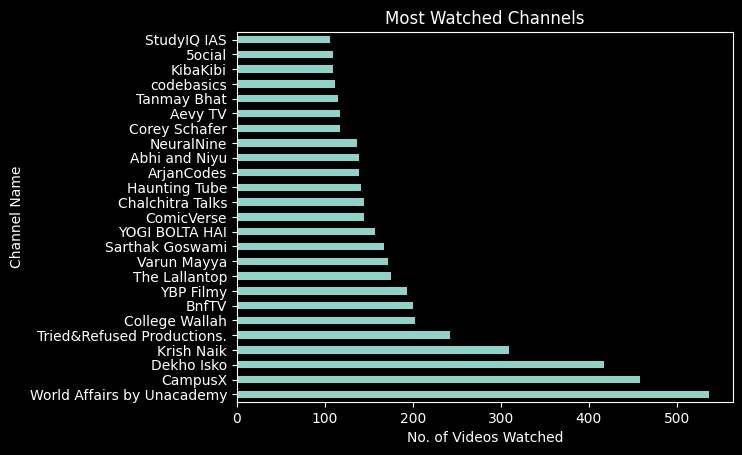

In [16]:
df["channelName"].value_counts().head(25).plot.barh(
    xlabel="No. of Videos Watched",
    ylabel="Channel Name",
    title="Most Watched Channels",
)
plt.show()

In [ ]:
threshold = 8
temp = df["channelName"].value_counts()

print(
    "There are %d channels whose (less than %d) videos you have watched overall."  # noqa: UP031
    % (len(temp[temp < threshold]), threshold)
)
print(
    "There are %d channels whose (more than %d) videos you have watched overall."  # noqa: UP031
    % (len(temp[temp > threshold]), threshold)
)

There are 2286 channels whose (less than 8) videos you have watched overall.
There are 198 channels whose (more than 8) videos you have watched overall.


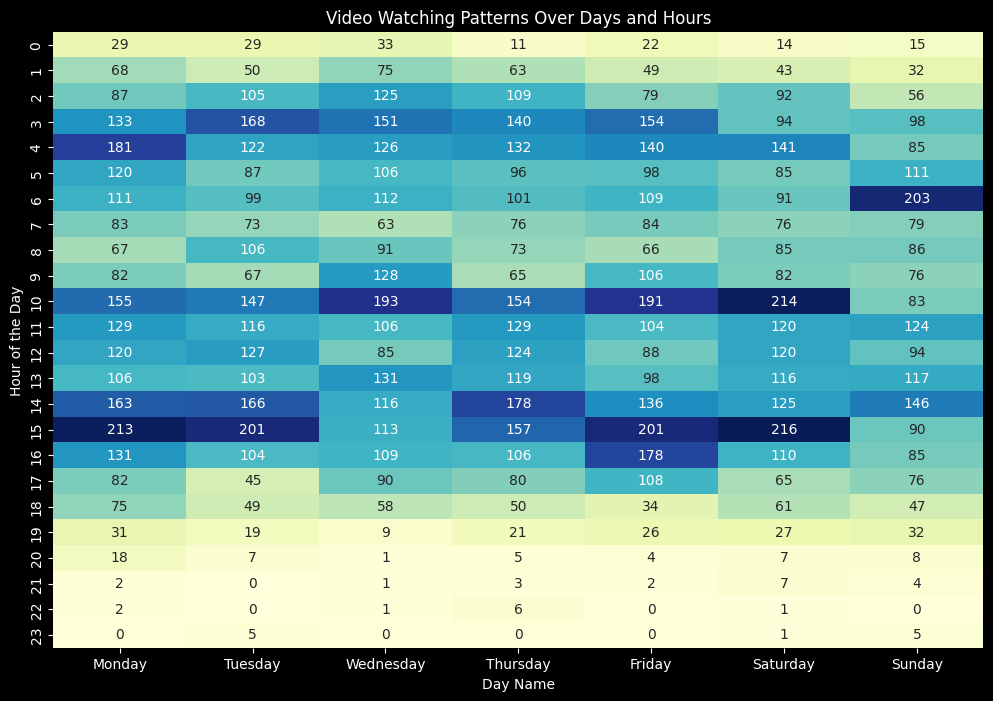

In [18]:
heatmap_data = df.pivot_table(index="hour", columns="day", aggfunc="size", fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=False, annot=True, fmt="d")
plt.title("Video Watching Patterns Over Days and Hours")
plt.xlabel("Day Name")
plt.ylabel("Hour of the Day")
plt.show()

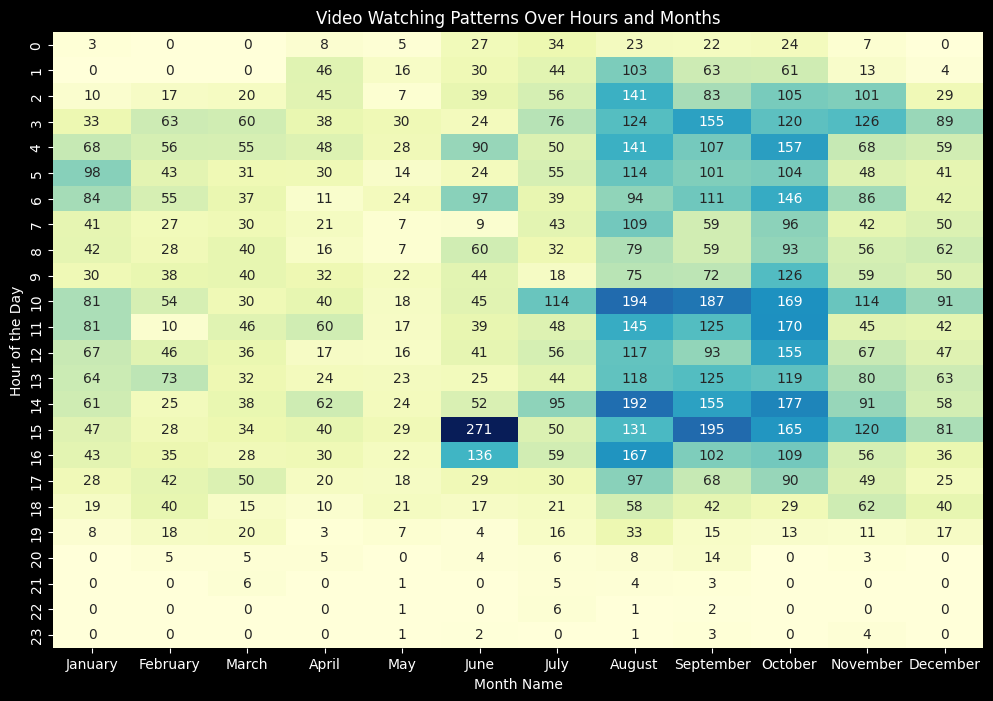

In [19]:
heatmap_data = df.pivot_table(
    index="hour", columns="month", aggfunc="size", fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=False, annot=True, fmt="d")
plt.title("Video Watching Patterns Over Hours and Months")
plt.xlabel("Month Name")
plt.ylabel("Hour of the Day")
plt.show()

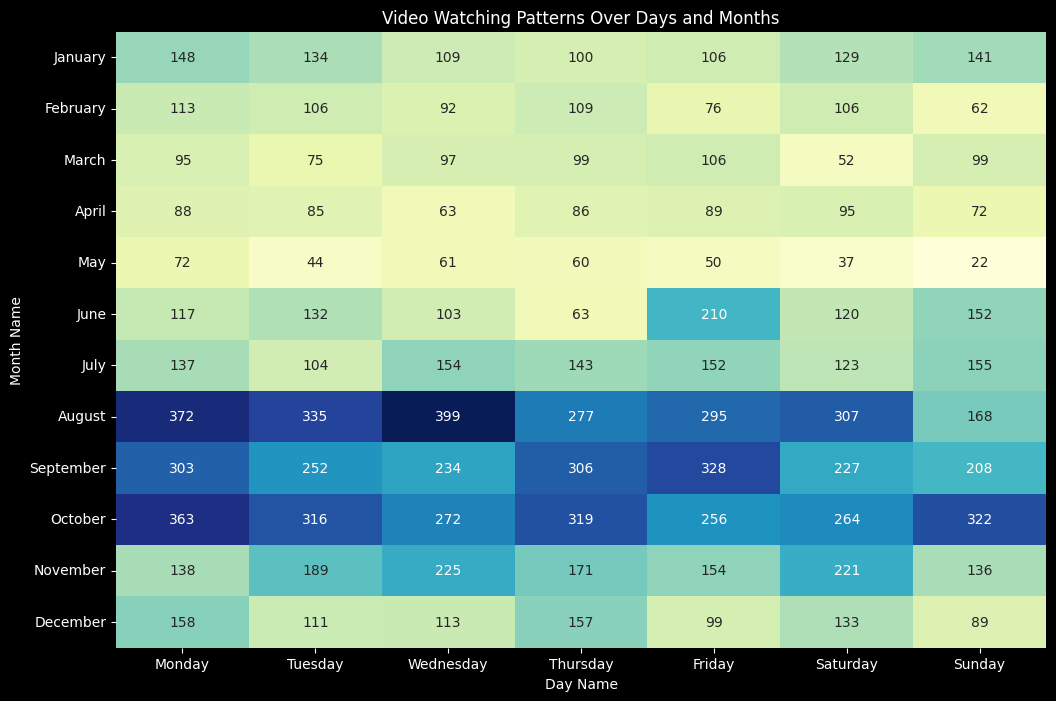

In [20]:
heatmap_data = df.query("isShorts==False").pivot_table(
    index="month", columns="day", aggfunc="size", fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=False, annot=True, fmt="d")
plt.title("Video Watching Patterns Over Days and Months")
plt.xlabel("Day Name")
plt.ylabel("Month Name")
plt.show()